# Here we are going to implement Mahalanobis distance and nearest neibhor matching algorithm 

## The main goal of this is to reduce the disimilarity between groups so that they can be used to perform statistical tests 

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.spatial import distance
from sklearn.preprocessing import Imputer
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [34]:
midatlantic = pd.read_csv('midatlantic_data.csv') 

In [35]:
midatlantic.index.names = ['sn']

In [36]:
midatlantic.head()

,id,score09,treatm,pretest,gender,african,hispanic,lses,age,cr08,absent,zip,hhincome,psvalue
sn,,,,,,,,,,,,,,
0,1279,-0.922322,0,0.370557,1,1,0,0,206,8,6,34319,46346.71964,0.027860
1,1863,-0.817309,0,1.051151,1,1,0,0,217,18,3,35479,59441.81508,0.015745
2,2224,0.521059,1,0.475264,0,0,0,1,227,22,3,35138,55866.77751,0.020323
3,1582,-1.311136,1,0.265850,1,0,1,0,236,19,30,34977,54593.37630,0.103497
4,1311,-0.190179,1,0.108790,1,0,0,1,195,2,45,35832,32160.75429,0.032780


In [37]:
ids=[int(i) for i in range(len(midatlantic))]

In [38]:
midatlantic=midatlantic.assign(ID=ids)

### Time to seperate the control and treatment groups

In [39]:
control_data=midatlantic.query('treatm==0')

In [40]:
control_data.head()

,id,score09,treatm,pretest,gender,african,hispanic,lses,age,cr08,absent,zip,hhincome,psvalue,ID
sn,,,,,,,,,,,,,,,
0,1279,-0.922322,0,0.370557,1,1,0,0,206,8,6,34319,46346.71964,0.027860,0
1,1863,-0.817309,0,1.051151,1,1,0,0,217,18,3,35479,59441.81508,0.015745,1
21,2465,0.960957,0,1.784098,0,1,0,0,222,21,18,34178,46795.86750,0.032315,21
22,1451,0.968113,0,1.208211,0,0,0,0,217,20,18,34448,82750.74299,0.013308,22
23,1443,-1.111734,0,0.056437,0,0,0,1,209,12,20,34513,56004.77955,0.023900,23


In [41]:
treatment_data=midatlantic.query('treatm==1')

In [42]:
treatment_data.head()

,id,score09,treatm,pretest,gender,african,hispanic,lses,age,cr08,absent,zip,hhincome,psvalue,ID
sn,,,,,,,,,,,,,,,
2,2224,0.521059,1,0.475264,0,0,0,1,227,22,3,35138,55866.77751,0.020323,2
3,1582,-1.311136,1,0.265850,1,0,1,0,236,19,30,34977,54593.37630,0.103497,3
4,1311,-0.190179,1,0.108790,1,0,0,1,195,2,45,35832,32160.75429,0.032780,4
5,2399,0.987368,1,0.632324,0,1,0,0,228,16,45,35082,33494.13883,0.169613,5
6,1693,-0.245387,1,0.108790,1,1,0,0,212,18,6,34923,55240.74165,0.013605,6


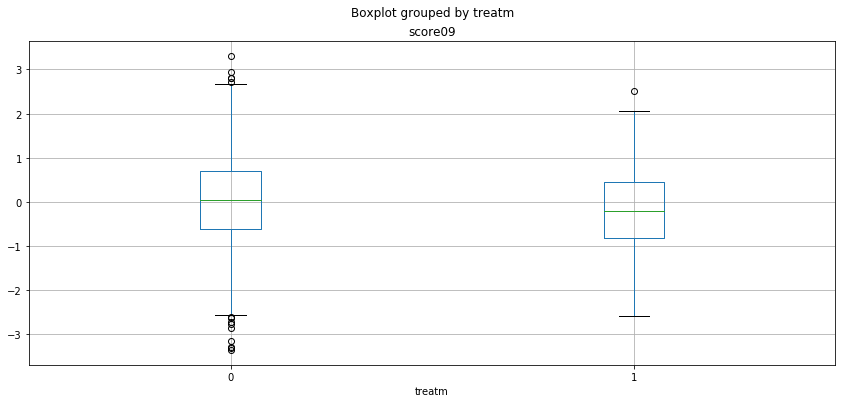

In [43]:
midatlantic.boxplot("score09", by="treatm", figsize = (14, 6)) 
plt.show()

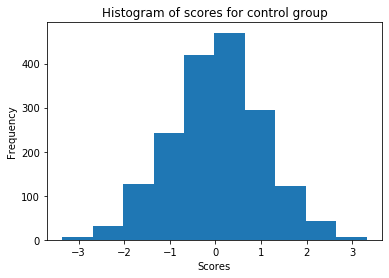

In [44]:
plt.hist(control_data['score09'], bins = 10) 
plt.title("Histogram of scores for control group") 
plt.xlabel("Scores") 
plt.ylabel("Frequency") 
plt.show();

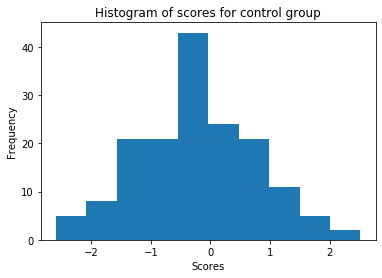

In [45]:
plt.hist(treatment_data['score09'], bins = 10) 
plt.title("Histogram of scores for control group") 
plt.xlabel("Scores") 
plt.ylabel("Frequency") 
plt.show();

### Performing a T-test to check the means of scores of the treatment and control groups

In [46]:
teststats_Mean, pvalue_Mean= stats.ttest_ind(control_data['score09'], treatment_data['score09'], equal_var=True)
print("T Test: This is a hypothesis test for the means of scores of control and treatment data") 
print("H0: Means of scores of control and treatment data are equal") 
print (f"test statistics (t): {teststats_Mean}") 
print(f"pvalue: {pvalue_Mean}")

alpha = 0.05 
if pvalue_Mean > alpha:    
    print("Decision: Fail to reject the null hypothesis")    
    print("Conclusion: Means of scores of control and treatment data are equal") 
else:    
    print("Decision: Reject the null hypothesis")    
    print("Conclusion: Means of scores of control and treatment data are unequal")


T Test: This is a hypothesis test for the means of scores of control and treatment data
H0: Means of scores of control and treatment data are equal
test statistics (t): 2.569128632462248
pvalue: 0.010270339156361484
Decision: Reject the null hypothesis
Conclusion: Means of scores of control and treatment data are unequal


## The Mahalanobis distance can be defined as:
   d(i,j) = $$((\vec{u} - \vec{v})^T {\rm \bf C}^{-1} (\vec{u} - \vec{v}) )$$

Where:\
i= individual from the treatment group

j= individual from the control group 

u= a vector of values of the matching variables for participant i in the treatment group.

v= a vector of values of the matching variables for participant j in the control group. 

C= the sample covariance matrix of the matching variables from the full set of individuals in the control group. 


In [47]:
control_data_cov=control_data.iloc[:,3:13]

In [48]:
#Calculating the covariance matrix
C=control_data_cov.cov()

In [49]:
C=np.array(C)

In [50]:
#Obtaining the inverse of the covariance matrix
C_inv=np.linalg.inv(C)

In [51]:
treatment_data_cov=treatment_data.iloc[:,3:13]

In [52]:
np.random.seed(2020)
randomized_cov = treatment_data_cov.sample(n=len(treatment_data_cov))
np.random.seed(2020)
randomized = treatment_data.sample(n=len(treatment_data))

 ## The Mahalanobis algorithm should be implemented as follows:
 
 #### 1) 1)	Randomly order or shuffle the treatment_data or treatment group (set a NumPy random seed to the number 2020). 
 
#### 2)		Calculate the Mahalanobis distance between the first individual i from the treatment group and each individual j in the
####          control group based on all the matching variables;

#### 3)	   Choose the individual j in the control group with the minimum distance d(i,\ j) as a match for the individual i in the
####         treatment group

#### 4)  	Considering that matching is done without replacement, remove both individual i\ and\ j from the pool or data, and
####          store the matched pair (or indexes of the matched individuals). 


#### 5)  		Repeat the above steps until matches are found for all individuals in the treatment group (Note, you can use the
####            indexes of the DataFrame to represent individual i in the treatment group and j\ in the control group) 


In [53]:
# Mahalanobis algorithm

randomized_mahal=randomized_cov.copy()
control_data_mahal=control_data_cov.copy()
ind_pairs_mahals=[]
while len(randomized_mahal)>0:
    mahals=[]
    for i in range(len(control_data_mahal)):
        u = randomized_mahal.iloc[0,:].values
        v = control_data_mahal.iloc[i,:].values
        dist=distance.mahalanobis(u,v, C_inv)
        dist=dist**2
        mahals.append(dist)
    c_ind=np.argmin(mahals)
    c=control_data.iloc[c_ind,:].ID
    t=randomized.iloc[0,:].ID
    ind_pairs_mahals.append([int(c),int(t)])
    randomized_mahal.drop(randomized_mahal.index[0],inplace=True)
    randomized.drop(randomized.index[0],inplace=True)
    control_data_mahal.drop(control_data_mahal.index[c_ind],inplace=True)
    control_data.drop(control_data.index[c_ind],inplace=True)
    np.random.seed(2020)
    randomized_mahal = randomized_mahal.sample(n=len(randomized_mahal))
    np.random.seed(2020)
    randomized = randomized.sample(n=len(randomized))

C:\Users\18482\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Now we need to obtain the corresponding treatment and control group rows

In [54]:
matched_tgroup=pd.DataFrame(columns = midatlantic.columns.values)
for i,j in ind_pairs_mahals:
    a=midatlantic.loc[midatlantic['ID'] == j].values
    matched_tgroup=matched_tgroup.append(pd.DataFrame(a.tolist(),columns = midatlantic.columns.values),ignore_index = True)

In [55]:
matched_cgroup=pd.DataFrame(columns = midatlantic.columns.values)
for i,j in ind_pairs_mahals:
    a=midatlantic.loc[midatlantic['ID'] == i].values
    matched_cgroup=matched_cgroup.append(pd.DataFrame(a.tolist(),columns = midatlantic.columns.values),ignore_index = True)

### Now let us redo the T test to check if our groups have equal means

In [56]:
teststats_Mean, pvalue_Mean= stats.ttest_ind(matched_tgroup['score09'],matched_cgroup['score09'], equal_var=True)
print("T Test: This is a hypothesis test for the means of scores of control and treatment data") 
print("H0: Means of scores of control and treatment data are equal") 
print (f"test statistics (t): {teststats_Mean}") 
print(f"pvalue: {pvalue_Mean}")

alpha = 0.05 
if pvalue_Mean > alpha:    
    print("Decision: Fail to reject the null hypothesis")    
    print("Conclusion: Means of scores of control and treatment data are equal") 
else:    
    print("Decision: Reject the null hypothesis")    
    print("Conclusion: Means of scores of control and treatment data are unequal")

T Test: This is a hypothesis test for the means of scores of control and treatment data
H0: Means of scores of control and treatment data are equal
test statistics (t): 0.23520460524452758
pvalue: 0.8142003742245206
Decision: Fail to reject the null hypothesis
Conclusion: Means of scores of control and treatment data are equal


## nearest neighbor matching algorithm can be defined as  the algorithm finds the minimum absolute propensity score difference: min || Pi - Pj || 



In [57]:
control_data=midatlantic.query('treatm==0')
control_data_cov=control_data.iloc[:,3:]
treatment_data_cov=treatment_data.iloc[:,3:]
np.random.seed(2020)
randomized_cov = treatment_data_cov.sample(n=len(treatment_data_cov))
np.random.seed(2020)
randomized = treatment_data.sample(n=len(treatment_data))

 ## The nearest neighbor matching algorithm should be implemented as follows:
 
 #### 1) Randomly order the individuals in the treatment group (treatement_data).
 
#### 2)	Select the first individual i in the treatment group and find the individual j  in the control group
####        (control_data) with the closest propensity score (psvalue). That means,  an individual j is  matched to 
####          individual i  if the absolute difference between their propensity scores is the smallest. So, the algorithm finds
####          the minimum absolute propensity score difference: minjPi-Pj. 

#### 3)	Matching is without replacement so, remove i and j from the pools or groups. 

#### 4)Repeat the above process until matches are found for all participants in the treatment group


In [58]:
## Propensity score matching algorithm.

randomized_prop=randomized_cov.copy()
control_data_prop=control_data_cov.copy()
ind_pairs_props=[]
while len(randomized_prop)>0:
    props=[]
    for i in range(len(control_data_prop)):
        u = randomized_prop.iloc[0,:].psvalue
        v = control_data_prop.iloc[i,:].psvalue
        dist=abs(u-v)
        props.append(dist)
    c_ind=np.argmin(props)
    c=control_data.iloc[c_ind,:].ID
    t=randomized.iloc[0,:].ID
    ind_pairs_props.append([int(c),int(t)])
    randomized_prop.drop(randomized_prop.index[0],inplace=True)
    randomized.drop(randomized.index[0],inplace=True)
    control_data_prop.drop(control_data_prop.index[c_ind],inplace=True)
    control_data.drop(control_data.index[c_ind],inplace=True)
    np.random.seed(2020)
    randomized_prop = randomized_prop.sample(n=len(randomized_prop))
    np.random.seed(2020)
    randomized = randomized.sample(n=len(randomized))

In [60]:
matched_tgroup2=pd.DataFrame(columns = midatlantic.columns.values)
for i,j in ind_pairs_props:
    a=midatlantic.loc[midatlantic['ID'] == j].values
    matched_tgroup2=matched_tgroup2.append(pd.DataFrame(a.tolist(),columns = midatlantic.columns.values),ignore_index = True)

In [61]:
matched_cgroup2=pd.DataFrame(columns = midatlantic.columns.values)
for i,j in ind_pairs_props:
    a=midatlantic.loc[midatlantic['ID'] == i].values
    matched_cgroup2=matched_cgroup2.append(pd.DataFrame(a.tolist(),columns = midatlantic.columns.values),ignore_index = True)

In [62]:
teststats_Mean, pvalue_Mean= stats.ttest_ind(matched_cgroup2['score09'], matched_tgroup2['score09'], equal_var=True)
print("T Test: This is a hypothesis test for the means of scores of control and treatment data") 
print("H0: Means of scores of control and treatment data are equal") 
print (f"test statistics (t): {teststats_Mean}") 
print(f"pvalue: {pvalue_Mean}")

alpha = 0.05 
if pvalue_Mean > alpha:    
    print("Decision: Fail to reject the null hypothesis")    
    print("Conclusion: Means of scores of control and treatment data are equal") 
else:    
    print("Decision: Reject the null hypothesis")    
    print("Conclusion: Means of scores of control and treatment data are unequal")

T Test: This is a hypothesis test for the means of scores of control and treatment data
H0: Means of scores of control and treatment data are equal
test statistics (t): 1.1173767901196623
pvalue: 0.26467146553578
Decision: Fail to reject the null hypothesis
Conclusion: Means of scores of control and treatment data are equal


## We have successfully made the population means similar using two different techniques which can now be used for further analysis. 